# Dimensionality reduction on trial features

In [3]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import identifiable_states_w_wheel, define_trial_types, state_relative_frequency
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

from one.api import ONE
one = ONE(mode='remote')

## Get data

In [2]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [3]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type01-08-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')
filename_wheel = str(results_path + 'mouse_movements_df01-08-2025')
extended = pd.read_parquet(filename_wheel, engine='pyarrow')

## Extend states

In [4]:
# Merge HMM states with wheel heuristic states
extended_short = extended[['trial_id', 'Bin', 'session', 'virtual_response', 'ballistic']]
all_states = states_file.merge(extended_short, on=['trial_id', 'Bin', 'session']).drop_duplicates()
states_trial_type = identifiable_states_w_wheel(all_states)  # Change identifiable state names to include wheel states info

# Compute features (state frequency) and organize sample keys for plotting

In [5]:
trial_type_agg = ['wsls', 'correct_str', 'choice', 'contrast_str']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice', 'virtual_response', 'ballistic']
trial_type_agg = ['correct_str', 'contrast_str']
trial_type_agg = ['ballistic']
trial_type_agg = ['correct_str']

order_0 = ['left', 'right']
order_1 = ['correct', 'incorrect']
order_1_1 = ['1.0',
    '0.25', 
    '0.125', 
    '0.0625', 
    '0.0']
order_1_2 = ['wst',
    'lst', 
    'wsh', 
    'lsh']
order_2 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 1.0', 
    'incorrect 0.25', 
    'incorrect 0.125', 
    'incorrect 0.0625', 
    'incorrect 0.0']
order_2_1 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 0.0', 
    'incorrect 0.0625', 
    'incorrect 0.125', 
    'incorrect 0.25', 
    'incorrect 1.0']
order_3 = ['correct 1.0 left', 'correct 1.0 right', 
    'correct 0.25 left', 'correct 0.25 right',
    'correct 0.125 left', 'correct 0.125 right',
    'correct 0.0625 left', 'correct 0.0625 right',
    'correct 0.0 left', 'correct 0.0 right',
    'incorrect 1.0 left', 'incorrect ct 0.0625 right',
    'incorrect 0.0 left', 'incorrect 0.0 right']

order_4 = ['correct 1.0 wst', 'correct 1.0 wsh', 'correct 1.0 lst', 'correct 1.0 lsh', 
    'correct 0.25 wst', 'correct 0.25 wsh', 'correct 0.25 lst', 'correct 0.25 lsh', 
    'correct 0.125 wst', 'correct 0.125 wsh', 'correct 0.125 lst', 'correct 0.125 lsh',
    'correct 0.0625 wst', 'correct 0.0625 wsh',   'correct 0.0625 lst', 'correct 0.0625 lsh',
    'correct 0.0 wst', 'correct 0.0 wsh', 'correct 0.0 lst', 'correct 0.0 lsh',
    'incorrect 1.0 wst', 'incorrect 1.0 wsh',  'incorrect 1.0 lst', 'incorrect 1.0 lsh', 
    'incorrect 0.25 wst', 'incorrect 0.25 wsh', 'incorrect 0.25 lst', 'incorrect 0.25 lsh',
    'incorrect 0.125 wst', 'incorrect 0.125 wsh', 'incorrect 0.125 lst', 'incorrect 0.125 lsh',
    'incorrect 0.0625 wst', 'incorrect 0.0625 wsh',  'incorrect 0.0625 lst', 'incorrect 0.0625 lsh',
    'incorrect 0.0 wst', 'incorrect 0.0 wsh', 'incorrect 0.0 lst', 'incorrect 0.0 lsh']

order_5 = ['correct wst', 'correct lst', 'correct wsh', 'correct lsh',
    'incorrect wst', 'incorrect lst',  'incorrect wsh', 'incorrect lsh']

order_6 = ['correct stay', 'correct shift',
    'incorrect stay', 'incorrect shift']

use_order = order_0

In [6]:
""" Define trial types  """
states_df = define_trial_types(states_trial_type, trial_type_agg)

""" Frequency of states per trial epoch  """
count, freq_df = state_relative_frequency(states_trial_type)

""" Append wheel states """
ballistic = pd.DataFrame(states_df.groupby(['sample', 'trial_type', 'mouse_name'])['ballistic'].mean()).reset_index()
virtual_resp = pd.DataFrame(states_df.groupby(['sample', 'trial_type', 'mouse_name'])['virtual_response'].mean()).reset_index()

merged_df = freq_df.merge(ballistic, on=['sample', 'trial_type', 'mouse_name'])
merged_df = merged_df.merge(virtual_resp, on=['sample', 'trial_type', 'mouse_name'])

""" Filter trial types """
keep_trials =  ['correct 1.0',
    'correct 0.25']
# merged_df = merged_df.loc[merged_df['trial_type'].isin(keep_trials)]

# Add timestamp for each trial
merged_df = merged_df.merge(states_df[['sample', 'goCueTrigger_times']].drop_duplicates(), on='sample')

In [7]:
merged_df['session'] = merged_df['sample'].str[:36]
use_key = 'trial_type' # session trial_typefilter

unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = merged_df[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
merged_df['numeric_trial_code'] = merged_df[use_key].map(map_to_use)

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(merged_df['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(merged_df['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = merged_df['mouse_name'].map(map_mouse_names)

## Prepare design matrix

In [8]:
var_names = merged_df.keys()[3:-5]
assert len(var_names) == 96 ## curently 96 = 4 trial epochs x 24 states

ori_X = np.array(merged_df[var_names]) #.values

print(np.shape(ori_X))

(136683, 96)


## UMAP assessment

In [13]:
repeats = 10
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Test for different random seeds

Text(0, 0.5, 'Negative log likelihood (SEM)')

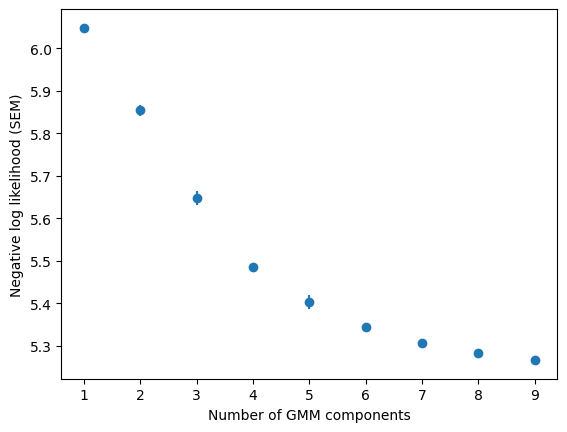

In [14]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    embeding = reducer.fit_transform(ori_X)
    embeding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_log_likelihood(embeding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')


## Run UMAP with fixed random seed

In [9]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

embedding = reducer.fit_transform(ori_X)
embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(136683, 2)

/tmp/ipykernel_25719/112867227.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


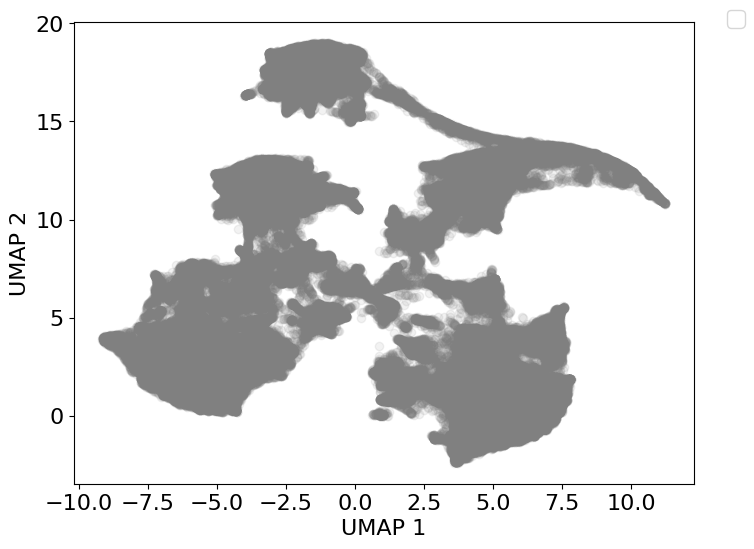

In [11]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.1,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'UMAP_grey', format="svg")

Text(0, 0.5, 'UMAP 2')

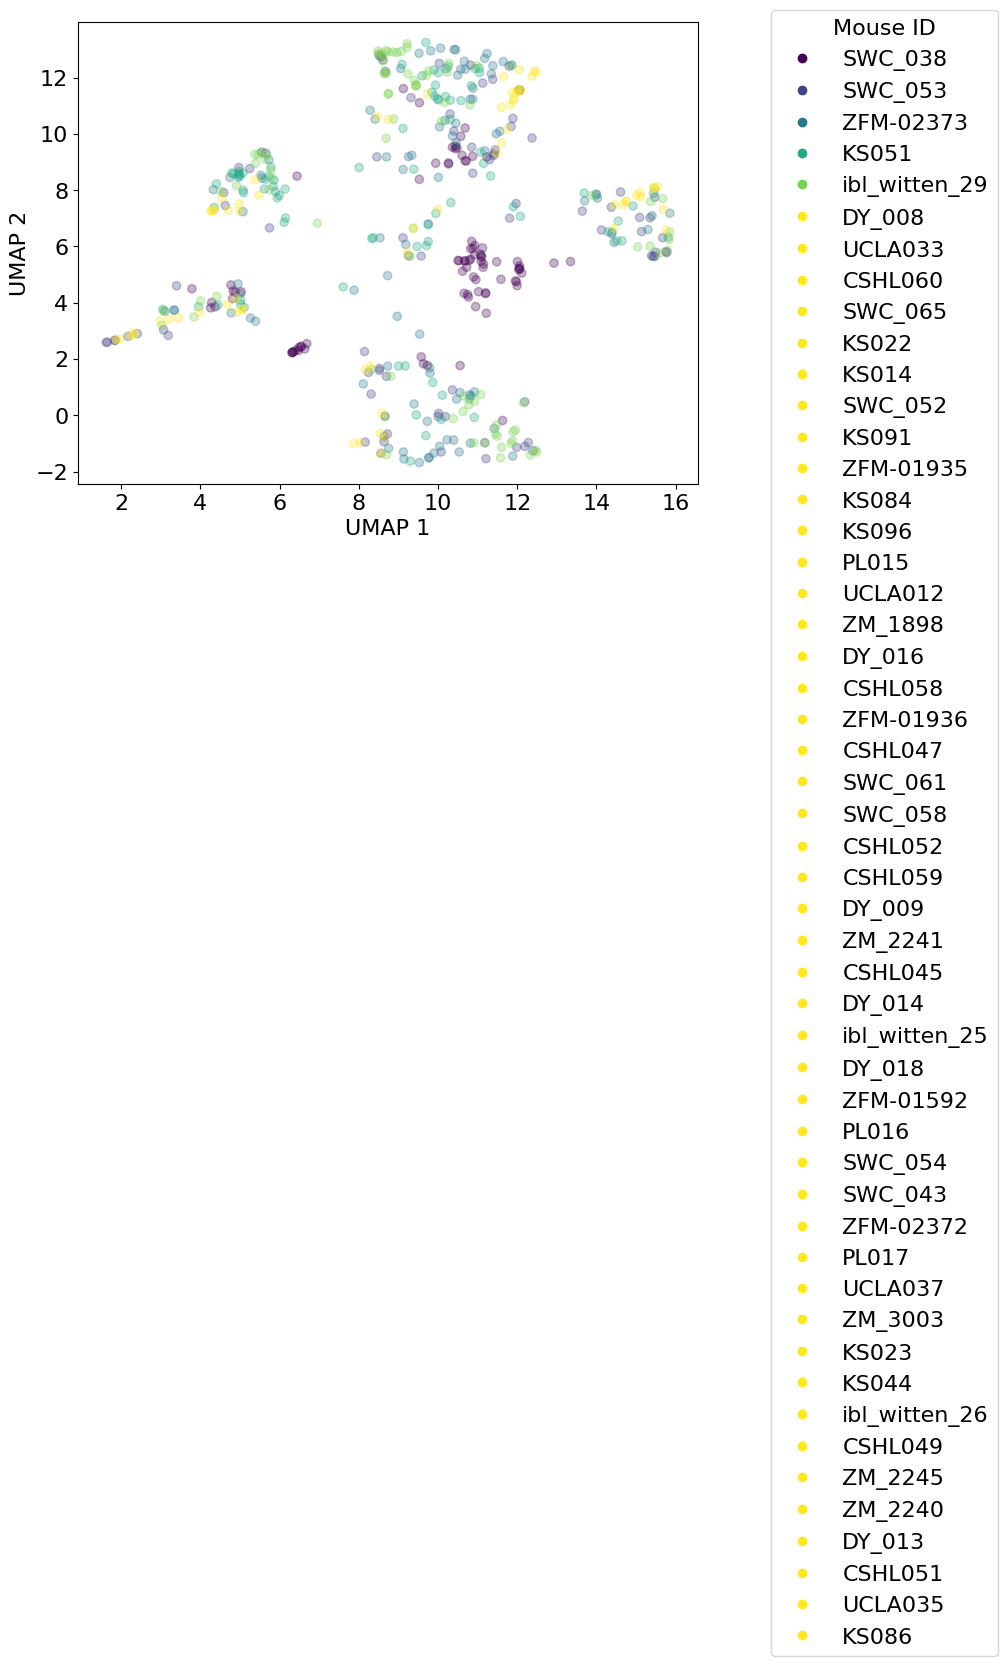

In [222]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0][0:500],
    embedding[:, 1][0:500],
    alpha=0.3,
    c=mouse_name_numbers[0:500],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], merged_df['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

Text(0, 0.5, 'UMAP 2')

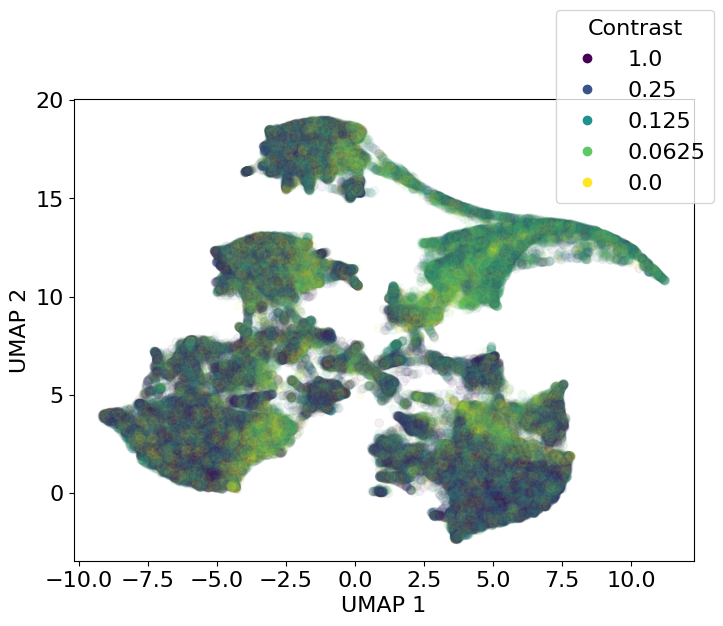

In [60]:
plt.figure(figsize=(8, 6))
filter = merged_df['trial_type'].isin(['incorrect stay', 'incorrect shift'])
filter = merged_df['trial_type'].isin(['correct stay', 'correct shift', 'incorrect stay', 'incorrect shift'])
filter = merged_df['trial_type'].isin(use_order)
plt.rcParams.update({'font.size': 16})

# Plotting the scatter plot
scatter = plt.scatter(
    embedding[:, 0][filter],
    embedding[:, 1][filter],
    c=merged_df.loc[filter, 'numeric_trial_code'],
    alpha=0.05,
    cmap='viridis'  # Choose a colormap
)  

# Create the custom legend
handles = []
for code, label in zip(unique_numeric_labels[0:], use_order[0:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# x.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Contrast", bbox_to_anchor=(.76, .75))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')

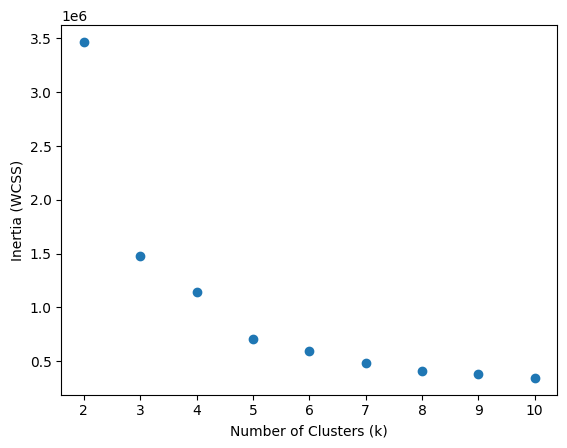

In [11]:
# Assuming `X` is your data
inertia_values = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.title('Elbow Method for Optimal k trials')
# Save the figure as an SVG file
plt.savefig(file_path+'inertia_trials.svg', format="svg")
plt.show()


## K-means clustering of data

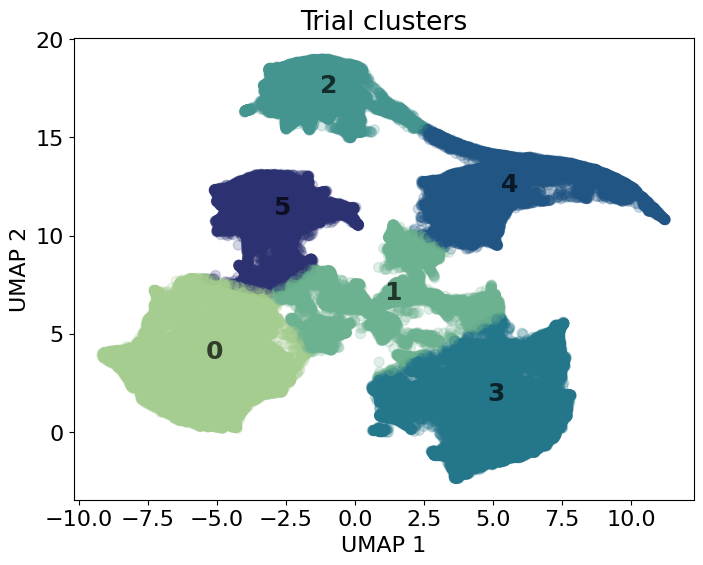

In [76]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans_trials = KMeans(n_clusters=6, random_state=2024)
kmeans_trials.fit(data_2d)
y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans_trials, s=50, alpha=0.2, cmap=sns.color_palette("crest", as_cmap=True)) # , cmap='Set2'

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')


plt.title("Trial clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'clusters_trials_1.svg', format="svg")
plt.show()


## Save trial clusters data

In [78]:
save_df = merged_df.copy()

In [92]:
# Analyze state features
save_df['UMAP1'] = embedding[:, 0]
save_df['UMAP2'] = embedding[:, 1]
save_df['cluster'] = y_kmeans_trials
df_cluster = count.reset_index().merge(save_df[['sample', 'cluster', 'session', 'goCueTrigger_times', 'UMAP1', 'UMAP2']], on='sample')
# df_cluster = df_cluster.merge(sum[['sample', 'broader_label', 'sum']], on=['sample', 'broader_label'])
df_cluster = df_cluster.merge(states_trial_type[['sample', 'reaction', 'response', 'elongation', 'perseverence', 
                                                 'choice', 'contrast', 'wsls', 'correct', 'block']].drop_duplicates(), on=['sample'])
df_cluster = df_cluster.merge(ballistic[['sample', 'ballistic']], on=['sample'])

In [95]:
file_to_save = df_cluster.copy()
filename = "cluster_per_trial"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
metadata = save_and_log(file_to_save, filename, file_format, save_path)